## Test create_instance

Tests for `create_instance`. The purpose is to convert an osmnx dataframe into the right raw format for the MCARPTIF solvers. The dataframe comes from OSM via networkx. The roadnetwork is initially stored as a bi-directional graph, with two-streets represented as opposing arcs. These are combined into a single edge.

The following board steps have to take place to transform the data frames into raw input files:

 1. Find two and one-way streets and combine all two-ways info into edges.
 2. Write the all the arc, edge and key problem instances into the correctly formatted text file.
 
More nuanced corner cases:

 1. Find arcs with the same start and end-nodes and split one vertex via a dummy arc.
 2. Split long arcs into sub-arcs (required when there's low vehicle capacity.

### Test modules

Nice magic that automatically reimports external modules that changed (don't have to restart the kernal) and making sure the source package path is accessible:

In [494]:
%load_ext autoreload
%autoreload 2

import os
import sys
import importlib
sys.path.insert(0, os.path.abspath('../../'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### General packages to use

In [495]:
import pandas as pd
import osmnx as ox
import numpy as np
import pydeck as pdk
import seaborn as sns
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as colors

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Test data

The following test data is generated. It requires an internet connecton.

In [496]:
test_location = [1.3707707, 103.7511237] # lat-lon in Singapore (Jurong) 

Custom osmnx filter

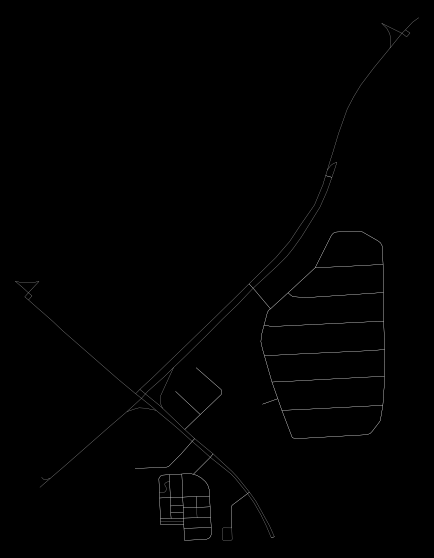

204

91

In [497]:
drive_service_all = '["area"!~"yes"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|corridor|elevator|escalator|proposed|construction|bridleway|abandoned|platform|raceway"]["motor_vehicle"!~"no"]["motorcar"!~"no"]'
exclude_emergency_services = '["service"!~"emergency_access"]'
exclude_custom_services = '["access"!~"private"]["service"!~"parking|parking_aisle|private|emergency_access"]'
exclude_parking_privarte_emergency = '["access"!~"private"]["service"!~"parking|private|emergency_access"]'
exclude_private = '["access"!~"private"]["service"!~"private"]'
custom_filter = drive_service_all + exclude_emergency_services

G = ox.graph_from_point(center_point=test_location, dist_type='network', dist=800, custom_filter=custom_filter)
fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2, bgcolor='k', fig_height=10)
G.number_of_edges()
G.number_of_nodes()

Converting the graph into geopandas datafile:

In [498]:
gdf_graph = ox.graph_to_gdfs(G)
gdf_nodes = gdf_graph[0]
gdf_arcs = gdf_graph[1].copy() # a bi-directional graph is returned, so the network has arcs, not edges.

Assigning the depot and intermediate facilities based on OSM keys.

In [499]:
depot_osm = 5184767962
inter_mediate_facilities_osm = [1844145095]

depot_vertex = gdf_nodes.loc[gdf_nodes['osmid'] == depot_osm].index.values[0]
inter_mediate_facility_vertex = gdf_nodes.loc[gdf_nodes['osmid'].isin(inter_mediate_facilities_osm)].index.values

We make all arcs and edges with `highway'=='residential` required arcs and edges. The rest are non-required. These are best fed as a seperate data.frame:

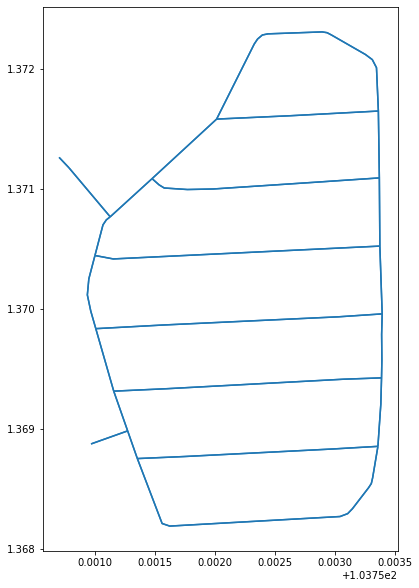

In [500]:
gdf_arcs_req = gdf_arcs.loc[gdf_arcs['highway'] == 'residential'].copy()
gdf_arcs_req['demand'] = 1 # each arc has unit demand
_ = gdf_arcs_req.plot(figsize=(10, 10))

Last things we need to specify is set a few basic input parameters:

In [501]:
capacity = 5 # units
maxtrip = 10 # units
demand_column = 'weight' # demand column in the data.frame
service_time_column = 'length' # service time columns in the data.frame
travel_time_column = 'length' # travel time columns in the data.frameb

In [502]:
gdf_arcs.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'length', 'geometry', 'lanes', 'service', 'access'],
      dtype='object')

And everything is setup for network conversion.

### Test pacakge

Packages to test.

In [503]:
from osmnx_network_extract import CreateMcarptifFormat
from osmnx_network_extract import PrepareRequiredArcs
from osmnx_network_extract import PrepareGraph
from osmnx_network_extract import create_arc_id
from osmnx_network_extract import convert_to_int
from osmnx_network_extract import test_column_type
from osmnx_network_extract import test_column_exists

#### Network conversion

Now for testing the package:

In [504]:
gdf_arcs_in = gdf_arcs.copy()
gdf_arcs_in['travel_cost'] = gdf_arcs_in['length']
prepare_g = PrepareGraph(gdf_arcs_in)
gdf_arcs_prep = prepare_g.prep_osmnx_graph()
gdf_arcs_prep

,u,v,key,osmid,oneway,name,highway,maxspeed,length,geometry,lanes,service,access,travel_cost,arc_id_orig,u_orig,v_orig,arc_id,arc_id_ordered
0,4736583680,248011098,0.0,536655833,True,Brickland Road,primary,60,10.470,"LINESTRING (103.74631 1.37109, 103.74639 1.37103)",NaN,NaN,NaN,10,4736583680-248011098-0,4.736584e+09,2.480111e+08,4736583680-248011098,4736583680-248011098
1,4736583680,4736583681,0.0,480692069,True,Choa Chu Kang Grove,tertiary,50,34.470,"LINESTRING (103.74631 1.37109, 103.74648 1.371...",2,NaN,NaN,34,4736583680-4736583681-0,4.736584e+09,4.736584e+09,4736583680-4736583681,4736583680-4736583681
2,1844145159,1844145150,0.0,644869356,False,Bukit Batok Driving Centre,service,NaN,15.657,"LINESTRING (103.74912 1.36748, 103.74912 1.36734)",2,driveway,permissive,15,1844145159-1844145150-0,1.844145e+09,1.844145e+09,1844145159-1844145150,1844145150-1844145159
3,1844145159,1844145162,0.0,644872425,False,Bukit Batok Driving Centre,service,NaN,27.501,"LINESTRING (103.74912 1.36748, 103.74936 1.36749)",4,driveway,permissive,27,1844145159-1844145162-0,1.844145e+09,1.844145e+09,1844145159-1844145162,1844145159-1844145162
4,1844145159,1844145135,0.0,644856904,False,Bukit Batok Driving Centre,service,NaN,57.507,"LINESTRING (103.74912 1.36748, 103.74898 1.367...",4,driveway,permissive,57,1844145159-1844145135-0,1.844145e+09,1.844145e+09,1844145159-1844145135,1844145135-1844145159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,3975116542,10880173257,NaN,NaN,False,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN,NaN,NaN,3975116542-10880173257,3975116542-10880173257
184,8786256836,1881200121,NaN,NaN,False,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN,NaN,NaN,8786256836-1881200121,1881200121-8786256836
187,10880173257,3975116542,NaN,NaN,False,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN,NaN,NaN,10880173257-3975116542,3975116542-10880173257
190,8786256830,1881200115,NaN,NaN,False,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,0,NaN,NaN,NaN,8786256830-1881200115,1881200115-8786256830


We can proceed to prepare the required arcs graph:

In [505]:
gdf_arcs_req = gdf_arcs_prep.loc[gdf_arcs_prep['highway']=='residential'].copy()
gdf_arcs_req['demand'] = 1
gdf_arcs_req['service_cost'] = gdf_arcs_req['length']
gdf_arcs_req

,u,v,key,osmid,oneway,name,highway,maxspeed,length,geometry,...,service,access,travel_cost,arc_id_orig,u_orig,v_orig,arc_id,arc_id_ordered,demand,service_cost
13,1881200143,1881200163,0.0,633279760,False,Pavilion Circle,residential,50,13.189,"LINESTRING (103.75070 1.37127, 103.75078 1.37118)",...,NaN,NaN,13,1881200143-1881200163-0,1.881200e+09,1.881200e+09,1881200143-1881200163,1881200143-1881200163,1,13.189
25,1881200157,1881200060,0.0,644804796,False,Pavilion Circle,residential,50,63.227,"LINESTRING (103.75337 1.37053, 103.75337 1.37110)",...,NaN,NaN,63,1881200157-1881200060-0,1.881200e+09,1.881200e+09,1881200157-1881200060,1881200060-1881200157,1,63.227
26,1881200157,3975116539,0.0,727552265,False,Pavilion Circle,residential,50,62.907,"LINESTRING (103.75337 1.37053, 103.75339 1.36996)",...,NaN,NaN,62,1881200157-3975116539-0,1.881200e+09,3.975117e+09,1881200157-3975116539,1881200157-3975116539,1,62.907
27,1881200157,1881200092,0.0,"[766407362, 766407363, 177696837]",False,Pavilion Rise,residential,50,264.718,"LINESTRING (103.75337 1.37053, 103.75286 1.370...",...,NaN,NaN,264,1881200157-1881200092-0,1.881200e+09,1.881200e+09,1881200157-1881200092,1881200092-1881200157,1,264.718
29,1881200163,1881200088,0.0,177696833,False,Pavilion Circle,residential,50,59.514,"LINESTRING (103.75078 1.37118, 103.75112 1.37077)",...,NaN,NaN,59,1881200163-1881200088-0,1.881200e+09,1.881200e+09,1881200163-1881200088,1881200088-1881200163,1,59.514
30,1881200163,1881200143,0.0,633279760,False,Pavilion Circle,residential,50,13.189,"LINESTRING (103.75078 1.37118, 103.75070 1.37127)",...,NaN,NaN,13,1881200163-1881200143-0,1.881200e+09,1.881200e+09,1881200163-1881200143,1881200143-1881200163,1,13.189
71,6879093670,3975116536,0.0,465758319,False,Pavilion Circle,residential,50,27.204,"LINESTRING (103.75127 1.36899, 103.75135 1.36875)",...,NaN,NaN,27,6879093670-3975116536-0,6.879094e+09,3.975117e+09,6879093670-3975116536,3975116536-6879093670,1,27.204
72,6879093670,1881200111,0.0,734532887,False,Pavilion Circle,residential,50,39.045,"LINESTRING (103.75127 1.36899, 103.75115 1.36932)",...,NaN,NaN,39,6879093670-1881200111-0,6.879094e+09,1.881200e+09,6879093670-1881200111,1881200111-6879093670,1,39.045
73,6879093670,6879093671,0.0,734532888,False,NaN,residential,50,36.065,"LINESTRING (103.75127 1.36899, 103.75096 1.36888)",...,NaN,NaN,36,6879093670-6879093671-0,6.879094e+09,6.879094e+09,6879093670-6879093671,6879093670-6879093671,1,36.065
74,6879093671,6879093670,0.0,734532888,False,NaN,residential,50,36.065,"LINESTRING (103.75096 1.36888, 103.75127 1.36899)",...,NaN,NaN,36,6879093671-6879093670-0,6.879094e+09,6.879094e+09,6879093671-6879093670,6879093670-6879093671,1,36.065


In [506]:
pre_req = PrepareRequiredArcs(gdf_arcs_req)
pre_req._test_graph_parameters()
pre_req._convert_to_int()
pre_req._consolidate_edges()
pre_req._df_graph_req
df_graph_req = pre_req._df_graph_req.copy()

,u,v,key,osmid,oneway,name,highway,maxspeed,length,geometry,...,service,access,travel_cost,arc_id_orig,u_orig,v_orig,arc_id,arc_id_ordered,demand,service_cost
0,1881200143,1881200163,0,633279760,False,Pavilion Circle,residential,50,13.189,"LINESTRING (103.75070 1.37127, 103.75078 1.37118)",...,NaN,NaN,13,1881200143-1881200163-0,1.881200e+09,1.881200e+09,1881200143-1881200163,1881200143-1881200163,2,13
1,1881200157,1881200060,0,644804796,False,Pavilion Circle,residential,50,63.227,"LINESTRING (103.75337 1.37053, 103.75337 1.37110)",...,NaN,NaN,63,1881200157-1881200060-0,1.881200e+09,1.881200e+09,1881200157-1881200060,1881200060-1881200157,2,63
2,1881200157,3975116539,0,727552265,False,Pavilion Circle,residential,50,62.907,"LINESTRING (103.75337 1.37053, 103.75339 1.36996)",...,NaN,NaN,62,1881200157-3975116539-0,1.881200e+09,3.975117e+09,1881200157-3975116539,1881200157-3975116539,2,62
3,1881200157,1881200092,0,"[766407362, 766407363, 177696837]",False,Pavilion Rise,residential,50,264.718,"LINESTRING (103.75337 1.37053, 103.75286 1.370...",...,NaN,NaN,264,1881200157-1881200092-0,1.881200e+09,1.881200e+09,1881200157-1881200092,1881200092-1881200157,2,264
4,1881200163,1881200088,0,177696833,False,Pavilion Circle,residential,50,59.514,"LINESTRING (103.75078 1.37118, 103.75112 1.37077)",...,NaN,NaN,59,1881200163-1881200088-0,1.881200e+09,1.881200e+09,1881200163-1881200088,1881200088-1881200163,2,59
5,6879093670,3975116536,0,465758319,False,Pavilion Circle,residential,50,27.204,"LINESTRING (103.75127 1.36899, 103.75135 1.36875)",...,NaN,NaN,27,6879093670-3975116536-0,6.879094e+09,3.975117e+09,6879093670-3975116536,3975116536-6879093670,2,27
6,6879093670,1881200111,0,734532887,False,Pavilion Circle,residential,50,39.045,"LINESTRING (103.75127 1.36899, 103.75115 1.36932)",...,NaN,NaN,39,6879093670-1881200111-0,6.879094e+09,1.881200e+09,6879093670-1881200111,1881200111-6879093670,2,39
7,6879093670,6879093671,0,734532888,False,NaN,residential,50,36.065,"LINESTRING (103.75127 1.36899, 103.75096 1.36888)",...,NaN,NaN,36,6879093670-6879093671-0,6.879094e+09,6.879094e+09,6879093670-6879093671,6879093670-6879093671,2,36
8,1881200060,1881200115,0,644804795,False,Pavilion Circle,residential,50,62.020,"LINESTRING (103.75337 1.37110, 103.75336 1.37165)",...,NaN,NaN,62,1881200060-1881200115-0,1.881200e+09,1.881200e+09,1881200060-1881200115,1881200060-1881200115,2,62
9,1881200060,1881200096,0,"[727744520, 177696840, 727744519]",False,Pavilion Grove,residential,50,214.117,"LINESTRING (103.75337 1.37110, 103.75285 1.371...",...,NaN,NaN,214,1881200060-1881200096-0,1.881200e+09,1.881200e+09,1881200060-1881200096,1881200060-1881200096,2,214


In [509]:
create_mcarptif = CreateMcarptifFormat(gdf_arcs_prep, df_graph_req)
create_mcarptif._check_graph_parameters()
create_mcarptif._check_type()
create_mcarptif.set_problem_parameters(name='test')
create_mcarptif._calc_graph_properties()
create_mcarptif.set_depot(depot_vertex)
create_mcarptif.set_ifs(inter_mediate_facility_vertex)

In [510]:
create_mcarptif._add_req_arc_str()
create_mcarptif._add_arc_str()

In [511]:
create_mcarptif._df_graph_req['out_str'][0]
create_mcarptif._df_graph['out_str'][0]
create_mcarptif._set_depot_str()
create_mcarptif._set_dump_str()
create_mcarptif._set_header_str()

'(1881200143,1881200163)   serv_cost   13   trav_cost   13   demand   2\n'

'(4736583680,248011098)   cost   10\n'

'DEPOT : 5184767962\n'

'DUMPING_SITES : 1844145095'

'NAME : test\nNODES : 21\nREQ_EDGES : 23\nNOREQ_EDGES : 137\nREQ_ARCS : 0\nNOREQ_ARCS : 52\nVEHICLES : 0\nCAPACITY : 0\nDUMPING_COST : 0\nMAX_TRIP : 0\n'

In [512]:
create_mcarptif.create_instance()

Checking inputs...
done
Converting inputs to string...
done


In [513]:
create_mcarptif._output_str

'NAME : test\nNODES : 21\nREQ_EDGES : 23\nNOREQ_EDGES : 137\nREQ_ARCS : 0\nNOREQ_ARCS : 52\nVEHICLES : 0\nCAPACITY : 0\nDUMPING_COST : 0\nMAX_TRIP : 0\nLIST_REQ_EDGES : \n(1881200143,1881200163)   serv_cost   13   trav_cost   13   demand   2\n(1881200157,1881200060)   serv_cost   63   trav_cost   63   demand   2\n(1881200157,3975116539)   serv_cost   62   trav_cost   62   demand   2\n(1881200157,1881200092)   serv_cost   264   trav_cost   264   demand   2\n(1881200163,1881200088)   serv_cost   59   trav_cost   59   demand   2\n(6879093670,3975116536)   serv_cost   27   trav_cost   27   demand   2\n(6879093670,1881200111)   serv_cost   39   trav_cost   39   demand   2\n(6879093670,6879093671)   serv_cost   36   trav_cost   36   demand   2\n(1881200060,1881200115)   serv_cost   62   trav_cost   62   demand   2\n(1881200060,1881200096)   serv_cost   214   trav_cost   214   demand   2\n(1881200088,1881200096)   serv_cost   52   trav_cost   52   demand   2\n(1881200088,1881200092)   serv_co

In [514]:
create_mcarptif = CreateMcarptifFormat(gdf_arcs_prep, df_graph_req, depot_vertex, inter_mediate_facility_vertex)
create_mcarptif.set_problem_parameters(name='test2', vehicles=10, capacity=4, dumping_cost=0, max_trip=30000)
create_mcarptif.create_instance(check_inputs=True)
file_name = 'output/test.txt'
create_mcarptif.write_instance(file_name)

Checking inputs...
done
Converting inputs to string...
done
Writing instance to `output/test.txt`...
done


### Final test

As a final test, we load the instance file, manually set some properties and solve it.

In [515]:
from solver import solve_store_instance
from converter import load_instance

In [516]:
info = load_instance(file_name, name_tuple=False, cache=False, overwrite=True)

'4 files will be overwritten'
['`output/test_info_lists_pickled.dat` exists',
 '`output/test_problem_info.dat` exists',
 '`output/test_sp_data_full.dat` exists',
 '`output/test_nn_list.dat` exists']
'Converting output/test.txt...'

Starting shortest path calculations (3 procedures)

    1 of 3: Initialise matrices
    2 of 3: Calculate shortest paths

        2 of 3: SP calc 1 out of 328
        2 of 3: SP calc 2 out of 328
        2 of 3: SP calc 3 out of 328
        2 of 3: SP calc 4 out of 328
        2 of 3: SP calc 5 out of 328
        2 of 3: SP calc 6 out of 328
        2 of 3: SP calc 7 out of 328
        2 of 3: SP calc 8 out of 328
        2 of 3: SP calc 9 out of 328
        2 of 3: SP calc 10 out of 328
        2 of 3: SP calc 11 out of 328
        2 of 3: SP calc 12 out of 328
        2 of 3: SP calc 13 out of 328
        2 of 3: SP calc 14 out of 328
        2 of 3: SP calc 15 out of 328
        2 of 3: SP calc 16 out of 328
        2 of 3: SP calc 17 out of 328
        2

In [517]:
solution = solve_store_instance(file_name, improve = 'LS', write_results=False, info=info)

Problem info supplied. Directly proceeding to solve problem.

Z: 27211 	 Savings: -118 	 Relocate arc 11 (R 0, T 0, P 2) before arc 38 (R 0, T 11, P 1) 	 relocatePreIF_PreIF 	 Feasible moves
I: 1 	 Saving: -118 	 # Moves 1 	 Moves made 1

 Fleet of 1 not reduced

Z: 27133 	 Savings: -78 	 Exchange arc 14 (R 0, T 5, P 2) with arc 11 (R 0, T 11, P 2) 	 exchange_1excPreIF_2excPreIF 	 Feasible moves
I: 2 	 Saving: -78 	 # Moves 2 	 Moves made 1

 Fleet of 1 not reduced

Z: 27079 	 Savings: -54 	 Exchange arc 16 (R 0, T 10, P 1) with arc 38 (R 0, T 11, P 1) 	 exchange_1excPostIF_2excPostIF 	 Feasible moves
Z: 27059 	 Savings: -20 	 Exchange arc 27 (R 0, T 1, P 2) with arc 10 (R 0, T 5, P 2) 	 exchange_1excPreIF_2excPreIF 	 Feasible moves
I: 3 	 Saving: -74 	 # Moves 4 	 Moves made 2

 Fleet of 1 not reduced

Z: 26941 	 Savings: -118 	 Relocate arc 24 (R 0, T 1, P 1) before arc 10 (R 0, T 1, P 2) 	 relocatePostIF_PreIF 	 Feasible moves
Z: 26599 	 Savings: -342 	 Relocate arc 38 (R 0, T 10, P

In [518]:
solution

,route,subroute,activity_id,arc_start_node,arc_end_node,activity_type,total_traversal_time_to_activity,activity_time,activity_demand,remaining_capacity,remaining_time,cum_demand,cum_time
0,0,0,0,5184767962,5184767962,depot_start,0,0,0,4,30000,0,0
1,0,0,187,5184767962,5184767961,traversal,0,148,0,4,29852,0,148
2,0,0,184,5184767961,5184767967,traversal,0,47,0,4,29805,0,195
3,0,0,50,5184767967,5014445207,traversal,0,29,0,4,29776,0,224
4,0,0,87,5014445207,243856692,traversal,0,8,0,4,29768,0,232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,0,11,13,243856675,5014445201,traversal,0,49,0,4,3767,0,26233
366,0,11,27,5014445201,5184767967,traversal,0,67,0,4,3700,0,26300
367,0,11,185,5184767967,5184767961,traversal,0,47,0,4,3653,0,26347
368,0,11,186,5184767961,5184767962,traversal,0,148,0,4,3505,0,26495


We store of these files for visualisation testing.

In [524]:
gdf_arcs_prep.to_csv('output/test_processed_full_arcs.csv', index=False)
df_graph_req.to_csv('output/test_processed_required_arcs.csv', index=False)
solution.to_csv('output/test_sol.csv', index=False)
nx.write_gpickle(G, 'output/test_graph_nx.pickle')